<a href="https://colab.research.google.com/github/aashmore/CV/blob/main/Anthony/New%20layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

See https://github.com/PhilipVinc/Lectures/tree/main and https://github.com/netket/netket/tree/master/Examples for more examples.

See also http://www.spintwo.net/Courses/Gauge-Theory-Student-Meetings/resources/Z2Ig.pdf for a map between 2d Ising and Z2 gauge theory.

# Ground State Variational Searches with NetKet

We start by recalling the Z2 gauge theory defined in 2012.05232:
$$H= - J \sum_{f\in F} B_f - h \sum_{e\in E}X_e,$$
where $B_f = \prod_{e\in f} Z_e$, where $F$ is the set of $1\times 1$ plaquettes on the lattice, $e\in f$ are the edges around the plaquette $f$, and $Z_e$ and $Z_e$ are the Pauli matrices.

Follwing the discussion in http://www.spintwo.net/Courses/Gauge-Theory-Student-Meetings/resources/Z2Ig.pdf, this should be dual to a standard 2d tranverse Ising model of the form
$$H= -J \sum_{i,j} \sigma_i^{(z)}\sigma_{j}^{(z)}- h \sum_i \sigma_i^{(x)} .$$

We start by checking this statement by computing the ground state energy in the the transverse Ising model and comparing with the results of 2012.05232. It seems they take $J=1$ and vary $h$ (see Figure S7 for example).

## Installing NetKet

On Google Colab, use the following command to install the required packages.

In [ ]:
pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!pip install --upgrade netket

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.9/485.9 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 28.0 MB/s eta 0:00:00


We also want to make sure that Jax is running on the CPU. It benefits from a GPU only for large numbers of spins.

In [2]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

Check the install was successful and print the version.

In [3]:
import netket as nk
print(f"NetKet version: {nk.__version__}")

import functools
from netket.operator.spin import sigmax, sigmaz
import flax.linen as nn
import jax.numpy as jnp

NetKet version: 3.8


## Defining the Hamiltonian

Start by defining the Hamiltonian of the system. We first define the degrees of freedom we are dealing with by specifying the Hilbert space of the problem. We start with an example of $N\times N$ spins on a lattice.

Number of edges in graph: 36
Number of nodes in graph: 18
List of edges in graph: [(12, 13), (5, 10), (8, 9), (9, 14), (1, 6), (2, 5), (11, 14), (2, 17), (7, 10), (7, 16), (4, 5), (12, 15), (3, 6), (4, 17), (14, 15), (8, 11), (0, 1), (10, 11), (11, 16), (0, 13), (13, 16), (6, 7), (7, 12), (3, 8), (4, 13), (14, 17), (5, 8), (0, 3), (9, 12), (1, 4), (2, 3), (0, 15), (1, 10), (2, 15), (6, 9), (16, 17)]


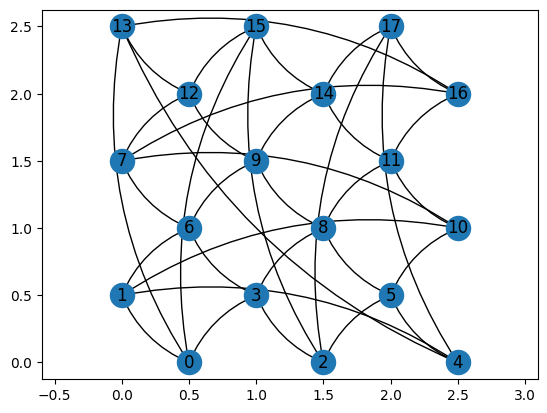

In [4]:
# size of lattice
nx = 3
ny = 3

graph = nk.graph.Lattice(basis_vectors=[[0,1],[1,0]],
                         site_offsets = [[1/2,0],[0,1/2]],
                         extent = [nx,ny],
                         pbc=True
                        )

# graph = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)

print("Number of edges in graph:",graph.n_edges)
print("Number of nodes in graph:",graph.n_nodes)

print("List of edges in graph:",graph.edges())

graph.draw()

# number of nodes in graph
N = graph.n_nodes

hi = nk.hilbert.Spin(s=1/2)**(N)

In [5]:
# generate a list of the positions of the links that form each 1-plaquette
# written for 2d at the moment, but simple to extend to higher dimensions
plaqs_pos_links = [[[0.5+i,0.+j],[(1.+i) % nx,0.5+j],[0.5+i,(1.+j) % ny],[0.+i,0.5+j]] for j in range (0,ny) for i in range(0,nx)]

# get list of ids for links in each 1-plaquette
plaqs_id_links = [tuple(graph.id_from_position(pos)) for pos in plaqs_pos_links]

# generate a list of the positions of the links associated to each site
# written for 2d at the moment, but simple to extend to higher dimensions
site_pos_links = [[[0.5+i,0.+j],[i,(0.5+j) % ny],[(-0.5+i) % nx,0.+j],[i,(-0.5+j) % ny]] for j in range (0,ny) for i in range(0,nx)]
# get list of ids for links associated to each site
site_id_links = [tuple(graph.id_from_position(pos)) for pos in site_pos_links]

print(plaqs_id_links)
print(site_id_links)

[(0, 3, 6, 1), (2, 5, 8, 3), (4, 1, 10, 5), (6, 9, 12, 7), (8, 11, 14, 9), (10, 7, 16, 11), (12, 15, 0, 13), (14, 17, 2, 15), (16, 13, 4, 17)]
[(0, 1, 4, 13), (2, 3, 0, 15), (4, 5, 2, 17), (6, 7, 10, 1), (8, 9, 6, 3), (10, 11, 8, 5), (12, 13, 16, 7), (14, 15, 12, 9), (16, 17, 14, 11)]


Now important Jax and generate two random states.

In [6]:
import jax

hi.random_state(key=jax.random.PRNGKey(0), size=1)

Array([[-1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
         1., -1., -1.,  1., -1.]], dtype=float32)

Next we specify the Hamiltonian. We use NetKet's LocalOperator function, which is the sum of arbitrary "$k$-local" operators. In our case, $\sigma_i^{(x)}$ is a 1-local operator, and $\sigma_i^{(z)}\sigma_{j}^{(z)}$ is a 2-local operator. Start by importing the Pauli matrices.

In [7]:
from netket.operator.spin import sigmax, sigmaz

Now set $J=1$ in the Hamiltonian and define the plaquette piece. NetKet automatically sees products of local operators as tensor products.

In [8]:
J = 1.

# H = sum([-J*sigmax(hilbert=hi, site=i) for i in range(N)])
H = sum([-J*sigmaz(hilbert=hi, site=i)*sigmaz(hilbert=hi, site=j)*
         sigmaz(hilbert=hi, site=k)*sigmaz(hilbert=hi, site=l) for (i,j,k,l) in plaqs_id_links])

Now add the local piece.

In [9]:
h = .2
# H = H + sum([-h*sigmax(hilbert=hi, site=i)*sigmaz(hilbert=hi, site=j) for (i,j) in graph.edges()])
H = H + sum([-h*sigmax(hilbert=hi, site=i) for i in range(N)])

Make a copy of the hamiltonian and add a penalty term to impose gauge invariance.

In [10]:
from scipy import sparse as _sparse

from netket.utils.types import DType as _DType

from netket.hilbert import AbstractHilbert as _AbstractHilbert

from netket.operator._local_operator import LocalOperator as _LocalOperator


def id_mat(
    hilbert: _AbstractHilbert, site: int, dtype: _DType = float
) -> _LocalOperator:
    """
    Builds the identity matrix operator acting on the `site`-th of the Hilbert
    space `hilbert`.

    If `hilbert` is a non-Spin space of local dimension M, it is considered
    as a (M-1)/2 - spin space.

    :param hilbert: The hilbert space
    :param site: the site on which this operator acts
    :return: a nk.operator.LocalOperator
    """
    import numpy as np

    N = hilbert.size_at_index(site)
    S = (N - 1) / 2

    D = [1 for a in np.arange(1, N+1)]
    mat = np.diag(D)
    mat = _sparse.coo_matrix(mat)
    return _LocalOperator(hilbert, mat, [site], dtype=dtype)

In [11]:
H_penalty = H.copy()

penalty = -10.

# H_penalty = H_penalty + sum([penalty*(sigmax(hilbert=hi, site=i)*sigmax(hilbert=hi, site=j)*
#           sigmax(hilbert=hi, site=k)*sigmax(hilbert=hi, site=l)-id_mat(hilbert=hi, site=i)*id_mat(hilbert=hi, site=j)*
#           id_mat(hilbert=hi, site=k)*id_mat(hilbert=hi, site=l))*(sigmax(hilbert=hi, site=i)*sigmax(hilbert=hi, site=j)*
#           sigmax(hilbert=hi, site=k)*sigmax(hilbert=hi, site=l)-id_mat(hilbert=hi, site=i)*id_mat(hilbert=hi, site=j)*
#           id_mat(hilbert=hi, site=k)*id_mat(hilbert=hi, site=l)) for (i,j,k,l) in site_id_links])

H_penalty = H_penalty + sum([penalty*(sigmax(hilbert=hi, site=i)*sigmax(hilbert=hi, site=j)*
           sigmax(hilbert=hi, site=k)*sigmax(hilbert=hi, site=l)) for (i,j,k,l) in site_id_links])

## Exact diagonalisation

We can start by trying exact diagonalisation. This works by converting the Hamiltonian operator in a sparse matrix of size $2^{N^2} \times 2^{N^2} = 1024 \times 1024$. This is just a standard scipy sparse matrix, so we can use any (sparse) matrix diagonalisation routine to find the eigensystem. For example, we can find the two lowest eigenstates via:

In [12]:
eig_vals, eig_vecs = nk.exact.lanczos_ed(H, k=5, compute_eigenvectors=True)

print("Eigenvalues with sparse solver:", eig_vals)

E_gs = eig_vals[0]

eig_vals_penalty, eig_vecs_penalty = nk.exact.lanczos_ed(H_penalty, k=5, compute_eigenvectors=True)

print("Eigenvalues with gauge penalty with sparse solver:", eig_vals_penalty)

print("Approx energy per site:", [(E - penalty * nx * ny)/(nx * ny) for E in  eig_vals_penalty])

E_gs_penalty = eig_vals_penalty[0]

Eigenvalues with sparse solver: [-9.21049564 -9.20198765 -9.20198765 -9.20198765 -9.19930773]
Eigenvalues with gauge penalty with sparse solver: [-99.21049564 -99.18657742 -99.18657742 -99.16605078 -96.67067606]
Approx energy per site: [-1.0233884042479058, -1.0207308239492459, -1.0207308239492237, -1.0184500867406427, -0.7411862288907779]


In [13]:
print("Approx energy per site:", [(E - penalty * nx * ny)/(nx * ny) for E in  eig_vals_penalty])

Approx energy per site: [-1.0233884042479058, -1.0207308239492459, -1.0207308239492237, -1.0184500867406427, -0.7411862288907779]


In [ ]:
print(eig_vecs[:,0].flatten()@(H@eig_vecs[:,0].flatten()))

print(eig_vecs_penalty[:,0].flatten()@(H@eig_vecs_penalty[:,0].flatten()))

-9.55577054356128
-9.555770543561277


## Neural network quantum state

In [14]:
# numerical operations in the model should always use jax.numpy
# instead of numpy because jax supports computing derivatives.
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax

# we refer to `flax.linen` as `nn`. It's a repository of
# layers, initializers and nonlinear functions.
import flax.linen as nn

In [ ]:
# A Flax model must be a class subclassing `nn.Module`
# The most compact way to define the model is this.
# The __call__(self, x) function should take as
# input a batch of states x.shape = (n_samples, L)
# and should return a vector of n_samples log-amplitudes
class FFN(nn.Module):

    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole
    # flax module.
    alpha : int = 1

    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        # bug in complex layers in flax has been fixed
        dense = nn.Dense(features=self.alpha * x.shape[-1], kernel_init=nn.initializers.normal(stddev=0.01))

        # we apply the dense layer to the input
        y = dense(x)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)

        # sum the output
        return jnp.sum(y, axis=-1)

# Create an instance of the model.
model = FFN(alpha=3)

# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

vstate.n_parameters

/usr/local/lib/python3.10/dist-packages/netket/vqs/mc/mc_state/state.py:58: UserWarning: n_samples=1000 (1000 per MPI rank) does not divide n_chains=16, increased to 1008 (1008 per MPI rank)
  warnings.warn(


12480

In [ ]:
# Then we create an optimiser from the standard library.
# You can also use optax.
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

# build the optimisation driver
# Notice the use of Stochastic Reconfiguration which considerably improves the optimisation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=nk.optimizer.SR(diag_shift=0.1))

log = nk.logging.RuntimeLog()

gs.run(n_iter=600, out=log)

ffn_energy = vstate.expect(H)

error = abs((ffn_energy.mean - E_gs)/E_gs)

print("Optimised energy and relative error:", ffn_energy,error)

100%|██████████| 600/600 [12:14<00:00,  1.22s/it, Energy=-71.9440 ± 0.0067 [σ²=0.0458, R̂=1.0045]]


Optimised energy and relative error: -71.9458 ± 0.0065 [σ²=0.0421, R̂=1.0060] 6.0269258045187195


Text(0, 0.5, 'Energy')

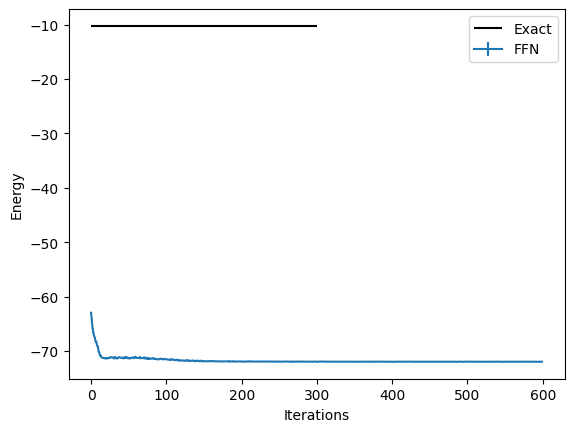

In [ ]:
data_FFN = log.data

from matplotlib import pyplot as plt

plt.errorbar(data_FFN["Energy"].iters, data_FFN["Energy"].Mean, yerr=data_FFN["Energy"].Sigma, label="FFN")
plt.hlines([E_gs], xmin=0, xmax=300, color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')

## Translation symmetry

In order to enforce spatial symmetries we can use some built-in functionalities of NetKet, in conjunction with equivariant layers.

The first step is to construct explicitly a graph that contains the edges of our interactions, in this case this is a simple chain with periodic boundaries. NetKet has builtin several symmetry groups that can be used to target specific spatial symmetries. In this case for example after constructing the graph we can also print its translation group.

In [ ]:
print(graph.translation_group())

PermutationGroup(elems=[Id(), Translation([0, 1]), Translation([0, 2]), Translation([0, 3]), Translation([0, 4]), Translation([0, 5]), Translation([0, 6]), Translation([0, 7]), Translation([1, 0]), Translation([1, 1]), Translation([1, 2]), Translation([1, 3]), Translation([1, 4]), Translation([1, 5]), Translation([1, 6]), Translation([1, 7]), Translation([2, 0]), Translation([2, 1]), Translation([2, 2]), Translation([2, 3]), Translation([2, 4]), Translation([2, 5]), Translation([2, 6]), Translation([2, 7]), Translation([3, 0]), Translation([3, 1]), Translation([3, 2]), Translation([3, 3]), Translation([3, 4]), Translation([3, 5]), Translation([3, 6]), Translation([3, 7]), Translation([4, 0]), Translation([4, 1]), Translation([4, 2]), Translation([4, 3]), Translation([4, 4]), Translation([4, 5]), Translation([4, 6]), Translation([4, 7]), Translation([5, 0]), Translation([5, 1]), Translation([5, 2]), Translation([5, 3]), Translation([5, 4]), Translation([5, 5]), Translation([5, 6]), Tran

Graphs are in general quite handy when defining hamiltonian terms on their edges. For example we can define our Hamiltonian as
```
Gamma=-1
H = sum([Gamma*sigmax(hi,i) for i in range(N)])

V=-1
H += sum([V*sigmaz(hi,i)*sigmaz(hi,j) for (i,j) in graph.edges()])
```



We now write a model with an invariant transformation given by the translation group. Notice that we now use NetKet's own nn module, instead of Flax, since it contains several additions.

In [ ]:
class SymmModel(nn.Module):
    alpha: int = 1

    @nn.compact
    def __call__(self, x):

        x = x.reshape(-1, 1, x.shape[-1])

        x = nk.nn.DenseSymm(symmetries=graph.translation_group(),
                           features=self.alpha,
                           kernel_init=nn.initializers.normal(stddev=0.01))(x)
        x = nn.relu(x)

        # sum the output
        return jnp.sum(x,axis=(-1,-2))


sampler = nk.sampler.MetropolisLocal(hi)

# Let us define a model with 3 features per symmetry
model=SymmModel(alpha=3)

vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

vstate.n_parameters

195

As it can be seen, the number of parameters of this model is greatly reduced, because of the symmetries that impose constraints on the weights of the dense layers. We can now optimize the model, using a few more optimization steps than before.

In [ ]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))

log=nk.logging.RuntimeLog()
gs.run(n_iter=600,out=log)

symm_energy=vstate.expect(H)
error=abs((symm_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",symm_energy,error)

100%|██████████| 600/600 [10:16<00:00,  1.03s/it, Energy=-53.21 ± 0.33 [σ²=108.90, R̂=1.0064]]


Optimized energy and relative error:  -51.78 ± 0.37 [σ²=139.23, R̂=1.0168] 4.0568590137078475


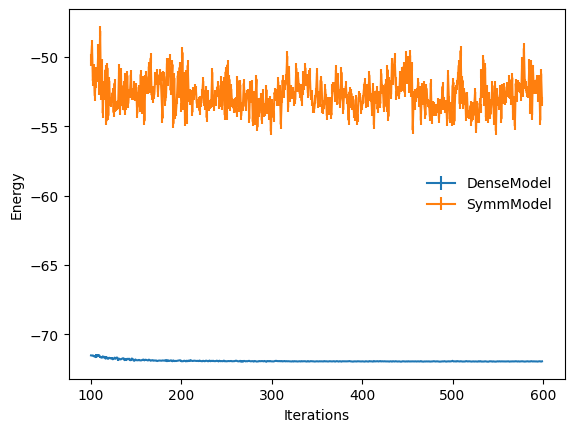

In [ ]:
plt.errorbar(data_FFN["Energy"].iters[100:],data_FFN["Energy"].Mean[100:],yerr=data_FFN["Energy"].Sigma[100:],label="DenseModel")
plt.errorbar(log.data["Energy"].iters[100:],log.data["Energy"].Mean[100:],yerr=log.data["Energy"].Sigma[100:],label="SymmModel")

#plt.axhline(y=eig_vals[0], xmin=0, xmax=log.data["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend(frameon=False)

## Other properties

Once the model has been optimized, we can of course measure also other observables that are not the energy. For example, we could decide to measure the value of the nearest-neighbor $\sigma^{(x)}-\sigma^{(x)}$ correlator. Notice that since correlators do not enjoy the zero-variance principle as the Hamiltonian instead does, it is important to use a larger number of samples to have a sufficiently low error bar on their measurement.

In [ ]:
corr = sum([sigmax(hi,i)*sigmax(hi,j) for (i,j) in graph.edges()])

vstate.n_samples=400000

vstate.expect(corr)

10.871 ± 0.018 [σ²=31.497, R̂=1.0002]

And we can further compare this to the exact diagonalisation result.

In [ ]:
psi = eig_vecs[:, 0]
exact_corr=psi@(corr.to_sparse()@psi)
print(exact_corr)

10.852248713127803


# New layers

In [16]:
from typing import Any, Callable, Sequence
from jax import lax, random
from flax.core import freeze, unfreeze

Simple dense layer

In [17]:
# We create one dense layer instance (taking 'features' parameter as input)
model = nn.Dense(features=5)

key1, key2 = random.split(random.PRNGKey(0))
x = random.normal(key1, (10,)) # Dummy input data
params = model.init(key2, x) # Initialization call
jax.tree_util.tree_map(lambda x: x.shape, params) # Checking output shapes

model.apply(params, x)

Array([ 3.24844799, -0.45773605,  0.49760698,  1.55063746,  0.17153964],      dtype=float64)

Example of a module built using setup

In [19]:
class ExplicitMLP(nn.Module):
  features: Sequence[int]

  def setup(self):
    # we automatically know what to do with lists, dicts of submodules
    self.layers = [nn.Dense(feat) for feat in self.features]
    # for single submodules, we would just write:
    # self.layer1 = nn.Dense(feat1)

  def __call__(self, inputs):
    x = inputs
    for i, lyr in enumerate(self.layers):
      x = lyr(x)
      if i != len(self.layers) - 1:
        x = nn.relu(x)
    return x

key1, key2 = random.split(random.PRNGKey(3), 2)
x = random.uniform(key1, (4,4))

model = ExplicitMLP(features=[3,4,5])
params = model.init(key2, x)
y = model.apply(params, x)

print('initialized parameter shapes:\n', jax.tree_util.tree_map(jnp.shape, unfreeze(params)))
print('output:\n', y)

initialized parameter shapes:
 {'params': {'layers_0': {'bias': (3,), 'kernel': (4, 3)}, 'layers_1': {'bias': (4,), 'kernel': (3, 4)}, 'layers_2': {'bias': (5,), 'kernel': (4, 5)}}}
output:
 [[-0.05828711  0.01930553 -0.01908771 -0.04724774 -0.0436595 ]
 [-0.56517608  0.18719451 -0.18508238 -0.45813379 -0.42334069]
 [-0.58939111  0.19521488 -0.19301226 -0.47776258 -0.44147877]
 [-0.89026194  0.29486766 -0.29154065 -0.72164957 -0.66684369]]
